In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import os
import tensorflow as tf

from keras.preprocessing.image import load_img , img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
# from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

# **Displaying Images**

In [2]:
picture_size = 48
folder_path = '../input/emotiondataset/data/'
# os.listdir(folder_path+"train/"+expression)  # gives the array of images    

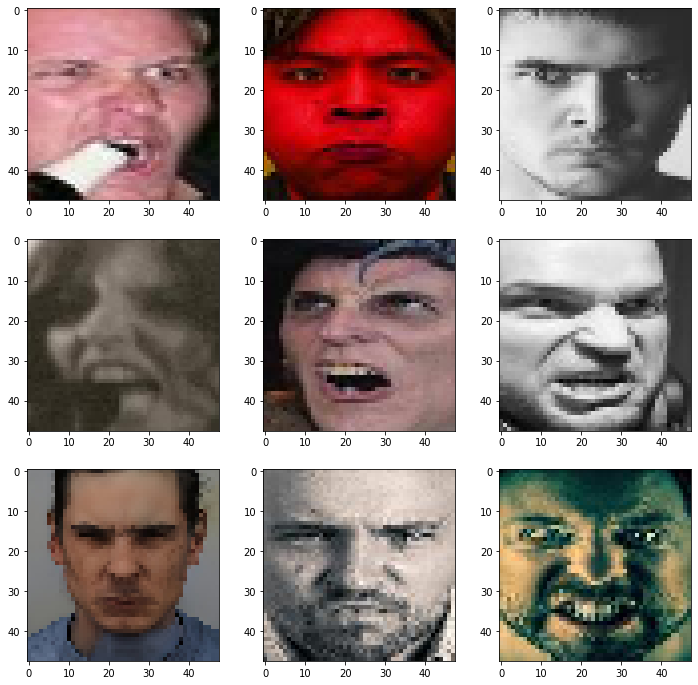

In [3]:
expression = 'angry'
plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path+"train/"+expression)[i],
                   target_size=(picture_size,picture_size))
    plt.imshow(img)
plt.show()

# Making training and Validaton Data

In [4]:
batch_size = 128 
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                             target_size=(picture_size,picture_size),
                                             color_mode = "grayscale",
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle=True)

test_set = datagen_val.flow_from_directory(folder_path+"test",
                                             target_size=(picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle=False)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 12895 images belonging to 7 classes.
Found 3147 images belonging to 7 classes.


In [5]:
no_of_classes = 7

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected first layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected second layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes , activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=["accuracy"])

model.summary()

2022-06-23 07:42:43.276628: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

# Fitting the Model with Training and Validation Data

In [6]:
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau

checkpoint = ModelCheckpoint('./model.h5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode="max")

# early_stopping = EarlyStopping(monitor="val_loss",
#                               min_delta=0,
#                               patience=1,
#                               verbose=1,
#                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor="val_loss",
                                       factor=0.2,
                                       patience=3,
                                       verbose=1,
                                       min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]
epochs = 50

In [7]:
history = model.fit_generator(generator=train_set,
                             steps_per_epoch=train_set.n//train_set.batch_size,
                              epochs=epochs,
                             validation_data = test_set,
                             validation_steps = test_set.n//test_set.batch_size,
                             callbacks = callbacks_list)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-23 07:42:44.828134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
100/100 [==============================] - 185s 2s/step - loss: 1.4798 - accuracy: 0.4761 - val_loss: 1.4635 - val_accuracy: 0.5101
Epoch 2/50
100/100 [==============================] - 180s 2s/step - loss: 1.0475 - accuracy: 0.6228 - val_loss: 1.1953 - val_accuracy: 0.5618
Epoch 3/50
100/100 [==============================] - 180s 2s/step - loss: 0.8821 - accuracy: 0.6784 - val_loss: 1.0137 - val_accuracy: 0.6204
Epoch 4/50
100/100 [==============================] - 179s 2s/step - loss: 0.7714 - accuracy: 0.7233 - val_loss: 0.8452 - val_accuracy: 0.7041
Epoch 5/50
100/100 [==============================] - 178s 2s/step - loss: 0.6897 - accuracy: 0.7501 - val_loss: 0.8798 - val_accuracy: 0.6787
Epoch 6/50
100/100 [==============================] - 178s 2s/step - loss: 0.6232 - accuracy: 0.7711 - val_loss: 1.3174 - val_accuracy: 0.6175
Epoch 7/50
100/100 [==============================] - 179s 2s/step - loss: 0.5672 - accuracy: 0.7922 - val_loss: 0.8431 - val_accuracy: 0.7012

In [8]:
model.save('model.h5')

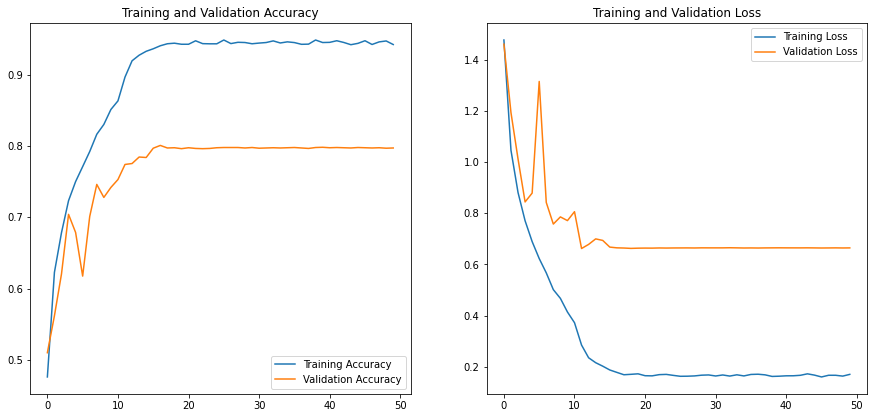

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()